# Part 1: Decision trees
* *There are two main kinds of decision trees depending on the type of output (numeric vs. categorical). What are they?*
* *Explain in your own words: Why is entropy useful when deciding where to split the data?*
* *Why are trees prone to overfitting?*
* *Explain (in your own words) how random forests help prevent overfitting.*

***[ANSWERS TO QUESTIONS]***

Loading the dataset, before we begin:

In [123]:
import requests
from matplotlib import pyplot as plt
import numpy as np
import csv
import pandas as pd
from pandas import DataFrame
%matplotlib inline
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap
import sklearn
from sklearn.tree import DecisionTreeClassifier,export_graphviz
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random as rn
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydot
import operator

In [2]:
# Load it into a Dataframe using pandas
path = '..\data\sfpd_incidents.csv'
df = pd.read_csv(path)
df.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)",15006027571000
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821003074
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821004014
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821015200
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,"(37.8004687042875, -122.431118543788)",15009822628160


*The chief wants you to start from real data and build a system that replicates the functionality in the Minority Report system. Imagine, we find out that certain type of crime is going to take place - as well as the exact time of the crime - but that we don't know where, then Suneman wants an algorithm that will predict which district the crime is most likely to take place in. Specifically, let's build an algorithm that predicts the location of a crime based on its type and time.*

* *Use the category of the crimes to build a decision tree that predicts the corresponding district. You can implement the ID3 tree in the DSFS book, or use the [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/tree.html) class in scikit-learn. For training, you can use 90% of the data and test the tree prediction on the remaining 10%.*

In order to fit the classifier, we must transform the data and convert all the string attributes to categorical attributes, since they're not supported by the DecisionTreeClassifier. Therefore, we use **one-out-of-K** coding in order to associate to each category its numerical representation. `scikit-learn` already provides us with a class made for this purpose, the `LabelEncoder`.

With `train_test_split` we're automatically splitting the whole dataset in training/test sets with the ratio suggested by the instructions. We hereby define the functions that will be useful later on:

In [99]:
# Split training and testing data
def split_dataset(X,Y):
    return train_test_split(X, Y, test_size=0.1, random_state=0)

#Train classifier and predict labels
def train_predict_tree_clf(X_train,Y_train,X_test):
    #Fit the classifier
    clf = DecisionTreeClassifier()
    if X_train.ndim==1:
        X_train = X_train[:,None]
    if Y_train.ndim==1:
        Y_train = Y_train[:,None]
    if X_test.ndim==1:
        X_test = X_test[:,None]
    clf.fit(X_train,Y_train)
    return clf.predict(X_test)

In [101]:
#Encoding categorical attributes
label_encoder = LabelEncoder()
X = label_encoder.fit_transform(df['Category'])
Y = label_encoder.fit_transform(df['PdDistrict'])

X_train, X_test, Y_train, Y_test = split_dataset(X,Y)
pred = train_predict_tree_clf(X_train,Y_train,X_test)

We re-convert the numerical values of `Y_test` and `pred` to categorical, since we'll need them for the next step.

In [102]:
pred = label_encoder.inverse_transform(pred)
Y_test = label_encoder.inverse_transform(Y_test)

* *What is the fraction of correct predictions?*

Let's create a function to compare the actual values with the predicted values and calculate the fraction of correct predictions as the ratio between the number of correct predictions and the length of the test set:

In [103]:
#Given the Y_test vector, the pred vector and the name of the predicted label, calculate the correctness ratio
def calculate_ratio(Y_test,pred,label,district_name=None):
    #Support dataframe with columns to compare
    df_predictions = DataFrame(np.column_stack([Y_test,pred]),columns=[label+'_Real',label+'_Pred'])
    total = len(df_predictions.index)
    
    #Calculate ratio
    num_correct_predictions = len(df_predictions[df_predictions[label+'_Real']==df_predictions[label+'_Pred']].index)
    ratio = num_correct_predictions*100.0/total
    district = '' if district_name==None else 'for district '+district_name
    print 'Fraction of correct predictions %s: %.2f%%' %(district,ratio)

And calculate the correctness ratio of our first prediction:

In [104]:
calculate_ratio(Y_test,pred,'PdDistrict')

Fraction of correct predictions : 20.29%


According to the output above, we guess the classifier didn't perform so well if we keep in consideration all the districts.

* *What are the correct predictions if you restrict the training/prediction to single districts (for example, predicting Mission vs. all other districts, etc)?*

We're supposed to perform a **Binary Classification**, by picking one district (e.g. **MISSION**) and labeling all other districts as **NOT MISSION**. Therefore, we'll have only *two values* for the labels (ideally 0 and 1, that's why *binary*) We'll manually convert to the string notation and let the Label Encoder do the rest.

In [62]:
#We remove NAN values
districts = list(set(df['PdDistrict'].dropna()))

#Function to get the binary representation of a specific value
def get_binary_repr(value,district):
    if value==district:
        return district
    return 'NOT'+district

for district in districts:
    df_binary_districts = df
    df_binary_districts['PdDistrict_Bin'] = df_binary_districts['PdDistrict'].apply(lambda x: get_binary_repr(x,district))

    # Split training and testing data (N.B. X is the same as before)
    Y = df_binary_districts['PdDistrict_Bin']
    Y = label_encoder.fit_transform(Y)
    X_train, X_test, Y_train, Y_test = split_dataset(X,Y)
    
    #Train classifier and predict
    pred = train_predict_tree_clf(X_train,Y_train,X_test)

    #Again re-converting to categorical values
    pred = label_encoder.inverse_transform(pred)
    Y_test = label_encoder.inverse_transform(Y_test)

    #Calculate fraction of correct predictions
    calculate_ratio(Y_test,pred,'PdDistrict',district)

Fraction of correct predictions for district CENTRAL: 89.99%
Fraction of correct predictions for district NORTHERN: 87.74%
Fraction of correct predictions for district SOUTHERN: 81.97%
Fraction of correct predictions for district PARK: 94.35%
Fraction of correct predictions for district MISSION: 86.62%
Fraction of correct predictions for district TENDERLOIN: 91.14%
Fraction of correct predictions for district RICHMOND: 94.75%
Fraction of correct predictions for district TARAVAL: 92.45%
Fraction of correct predictions for district INGLESIDE: 91.05%
Fraction of correct predictions for district BAYVIEW: 89.95%


In light of the above results, we could definitely say that reducing the problem to a binary classification problem makes more sense in terms of correct predictions.

* *Compare it to the random guess, what would you get if you'd guess a district randomly?*

In [63]:
def random_guess():
    return rn.choice(districts)

Y = df['PdDistrict']
pred = np.array([random_guess() for _ in range(len(df.index))])

#Calculate fraction of correct predictions
print '--- Random guess ---'
calculate_ratio(Y,pred,'PdDistrict')

--- Random guess ---
Fraction of correct predictions : 9.99%


* *And if you'd guess always one of the districts (for example the district with the most crimes)?*

Let's count the crimes per district and see the highest values:

In [64]:
top_districts = df.groupby('PdDistrict')['PdDistrict'].count().reset_index(name='Count').sort_values(by='Count',ascending=False)
top_districts.head()

,PdDistrict,Count
7,SOUTHERN,364516
3,MISSION,273386
4,NORTHERN,246991
0,BAYVIEW,203841
1,CENTRAL,202342


In [65]:
#With this function we will always guess the district with the highest number of crimes
def random_guess_tricky(district):
    if district==top_districts['PdDistrict'][0]:
        return district
    else:
        return rn.choice(districts)

pred = df['PdDistrict'].apply(lambda x: random_guess_tricky(x))

#Calculate fraction of correct predictions
print '--- Random guess tricky ---'
calculate_ratio(Y,pred,'PdDistrict')

--- Random guess tricky ---
Fraction of correct predictions : 19.02%


We can see that with this tweaked version of the random guess the fraction of correct predictions rises a little but still it's unsufficient to be considered reliable.

* *Now, add the day of the week to the features, do any of the the performance measures improve?*

In [66]:
X = df.filter(items=['Category','DayOfWeek'])
X_cat = label_encoder.fit_transform(X['Category'])
X_weekday = label_encoder.fit_transform(X['DayOfWeek'])
X = np.column_stack((X_cat,X_weekday))
Y = label_encoder.fit_transform(df['PdDistrict'])

#Training and prediction
X_train, X_test, Y_train, Y_test = split_dataset(X,Y)
clf = DecisionTreeClassifier()
clf.fit(X_train,Y_train[:,None])
print 'Fraction of correct predictions : %.2f%%' % (clf.score(X_test,Y_test[:,None])*100)

Fraction of correct predictions : 20.28%


Again, no improvements even by adding a new feature to the classifier.
* ***OPTIONAL***: *Visualize the tree so that you can see what it actually does! For visualization, you can use the export_graphviz method of scikit-learn and then convert the .dot file to a PDF.*

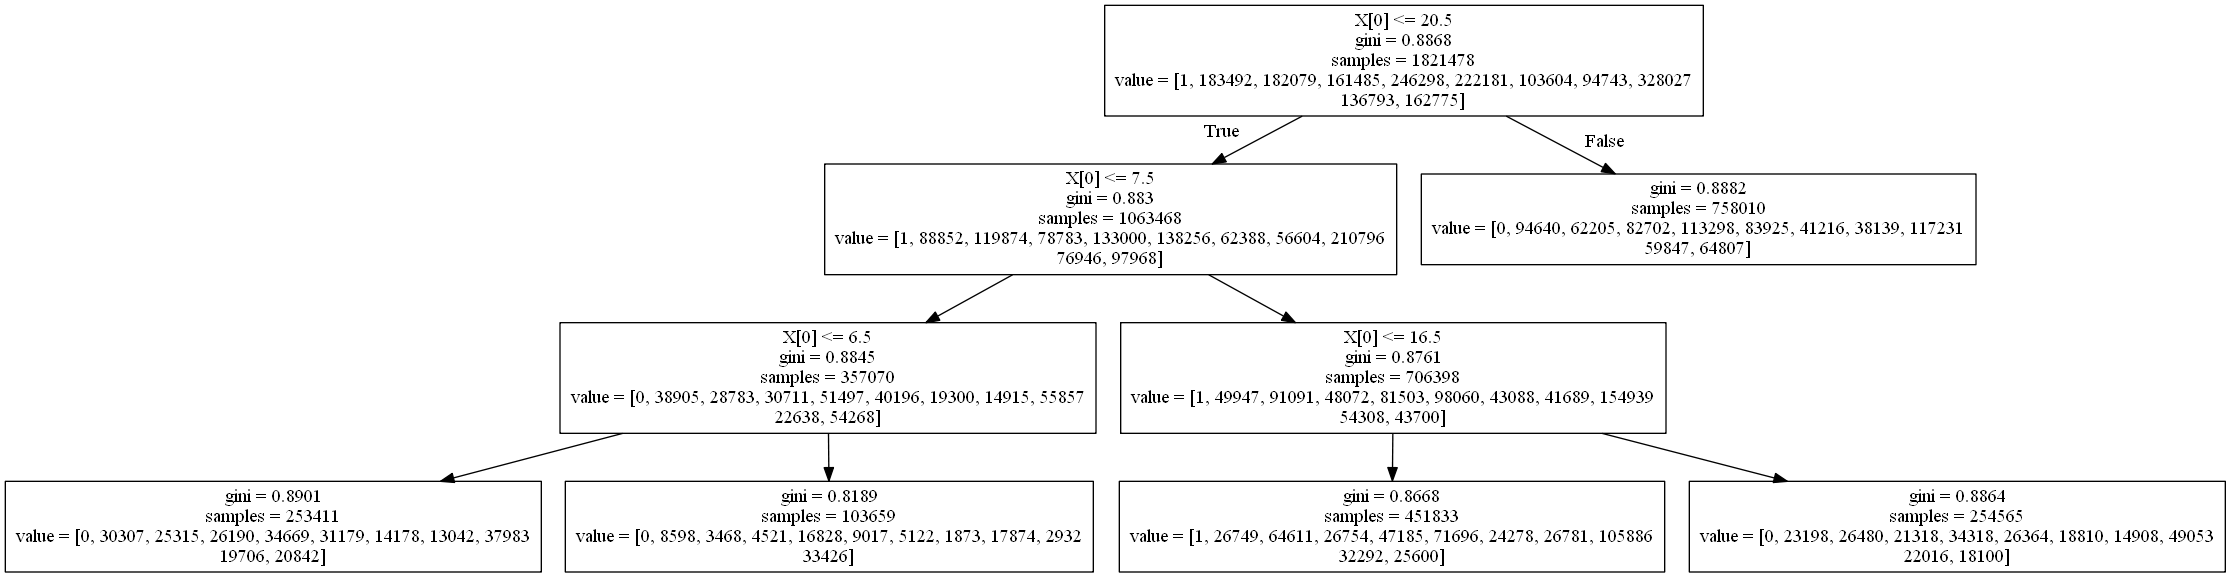

In [13]:
def show_tree(X_train,Y_train):
    clf = DecisionTreeClassifier(max_leaf_nodes=5)
    clf.fit(X_train,Y_train)
    dot_data = StringIO()  
    export_graphviz(clf, out_file=dot_data)  
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
    return Image(graph.create_png()) 
    
show_tree(X_train,Y_train[:,None])

* *As you might see in the visualization, the tree runs out of possible feature values to check before refining the decision. Try increasing the number of features: add part of the day (night=0-5, morning=6-10, midday=11-14, afternoon=15-17, evening=18-23). Is it better? What is the problem we're solving by breaking the day into parts rather than raw hour values?*

In [131]:
#Return the time of day, given the time of the crime
def get_part_of_day(time):
    hour = int(time.split(':')[0])
    if hour>=0 and hour<6:
        return 'night'
    elif hour>=6 and hour<11:
        return 'morning'
    elif hour>=11 and hour<15:
        return 'midday'
    elif hour>=15 and hour<18:
        return 'afternoon'
    else:
        return 'evening'

#Encoding and extracting features and labels
df['PartOfDay'] = df['Time'].apply(lambda x: get_part_of_day(x))
X = df.filter(items=['Category','DayOfWeek','PartOfDay'])
X_cat = label_encoder.fit_transform(X['Category'])
X_weekday = label_encoder.fit_transform(X['DayOfWeek'])
X_part_of_day = label_encoder.fit_transform(X['PartOfDay'])
X = np.column_stack((X_cat,X_weekday,X_part_of_day))
Y = label_encoder.fit_transform(df['PdDistrict'])

#Training and prediction
X_train, X_test, Y_train, Y_test = split_dataset(X,Y)
pred = train_predict_tree_clf(X_train,Y_train,X_test)
calculate_ratio(Y_test,pred,'PdDistrict')

Fraction of correct predictions : 20.42%


Again, it's obvious that adding another feature doesn't improve the performance of the classifier.
We split the hours into buckets in order to minimize the range of the values of this new feature and eventually, improve the performance of the classifier.

* *Let's try some examples to see if the algorithm is working.*

In [132]:
#Creating dictionary to keep track of encoded values
def get_encoding_dict(data):
    encoding_dict = {}
    le = LabelEncoder()
    data_en = le.fit_transform(data)
    for i,item in enumerate(data):
        encoding_dict[item] = data_en[i]
    return encoding_dict

#Before encoding, get encoding dictionaries
category_encoding_dict = get_encoding_dict(df['Category'])
weekday_encoding_dict = get_encoding_dict(df['DayOfWeek'])
daytime_encoding_dict = get_encoding_dict(df['PartOfDay'])
district_encoding_dict = get_encoding_dict(df['PdDistrict'].dropna())

Now that we have all the encoding dictionaries, it's easy to retrieve whatever value we want:

* *There is a new crime (prositution) on Monday 10pm. What are the three most likely districts?*

In [143]:
#Training the classifier and predicting the probabilities
def predict_probabilities(X_train,Y_train,category,weekday,daytime):
    clf = DecisionTreeClassifier()
    clf.fit(X_train,Y_train)
    probabilities = clf.predict_proba(np.array([category,weekday,daytime]).reshape(1,-1))[0]
    probabilities = {key:probabilities[i]*100
                     for key, value in district_encoding_dict.iteritems()
                     for i,label in enumerate(clf.classes_)
                     if value == label}
    return sorted(probabilities.items(),key=operator.itemgetter(1),reverse=True)

category = category_encoding_dict['PROSTITUTION']
weekday = weekday_encoding_dict['Monday']
daytime = daytime_encoding_dict['evening']

probabilities = predict_probabilities(X_train,Y_train,category,weekday,daytime)

In [144]:
probabilities

[('NORTHERN', 66.180758017492707),
 ('PARK', 11.661807580174926),
 ('INGLESIDE', 7.5801749271137027),
 ('TARAVAL', 3.4985422740524781),
 ('TENDERLOIN', 2.6239067055393588),
 ('CENTRAL', 0.58309037900874638),
 ('MISSION', 0.29154518950437319),
 ('RICHMOND', 0.29154518950437319),
 ('SOUTHERN', 0.0),
 ('BAYVIEW', 0.0)]

* *Also find the most likely districts for a gambling on Wednesday 1pm.*
* *And also try out an arson case on Sunday 7am?*

* *It's unlikely that the classifier overfits in our case. Explain why.*